In [1]:
# Q 4 & 5
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

df45 = pd.read_csv("NTSBAviationData.csv", encoding='utf-8', encoding_errors='replace')
df45.info()

df45['Event.Date'] = pd.to_datetime(df45['Event.Date'], errors='coerce')
## Create a column "Year" for analysis
df45['Year'] = df45['Event.Date'].dt.year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

C:\Users\sz606\AppData\Local\Temp\ipykernel_30336\898858822.py:7: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df45 = pd.read_csv("NTSBAviationData.csv", encoding='utf-8', encoding_errors='replace')


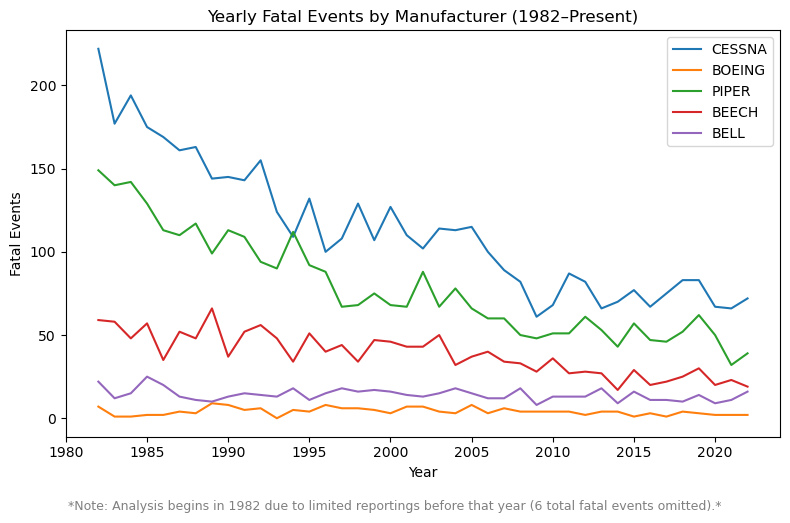

In [2]:
# Normalize make/model
df45.loc[:, 'Make']  = df45['Make'].str.strip().str.upper()
df45.loc[:, 'Model'] = df45['Model'].str.strip().str.upper()
df45['Make'].value_counts().head(10)

# Injuries → ints, derived flags
inj_cols = ['Total.Fatal.Injuries','Total.Serious.Injuries','Total.Minor.Injuries','Total.Uninjured']
df45[inj_cols] = df45[inj_cols].fillna(0)
df45[inj_cols] = df45[inj_cols].astype(int)

df45.loc[:, 'Total.Persons'] = df45[inj_cols].sum(axis=1)
df45.loc[:, 'FatalEvent']    = df45['Total.Fatal.Injuries'] > 0
df45.loc[:, 'SeriousEvent']  = df45['Total.Serious.Injuries'] > 0
df45.loc[:, 'MinorEvent']    = df45['Total.Minor.Injuries'] > 0
df45.loc[:, 'Injury.Severity'] = df45['Injury.Severity'].str.upper().fillna('UNKNOWN')

# Create a severity order & phase + amateur for later analysis
severity_order = ['FATAL', 'SERIOUS', 'MINOR', 'NONE', 'UNKNOWN']
df45.loc[:, 'Broad.phase.of.flight'] = df45['Broad.phase.of.flight'].str.strip().str.upper().fillna('UNKNOWN')
df45 = df45[df45['Make'].notna() & (df45['Make'] != 'UNKNOWN')].copy()
df45['Amateur.Built'] = df45['Amateur.Built'].map({'Y': 'Amateur Built', 'N': 'Certified', None: 'Unknown'})

# Aggregate for comparison
manufacturer_stats = (
    df45.groupby('Make')[['FatalEvent', 'Total.Fatal.Injuries']].sum()
    .assign(Total=df45.groupby('Make').size())
    .sort_values('Total.Fatal.Injuries', ascending=False)
)
manufacturer_stats['FatalRate'] = manufacturer_stats['FatalEvent'] / manufacturer_stats['Total']

# Choose starting year for consistent trend
start_year = 1982

# Build yearly trend summary
trend = (
    df45.groupby(['Year', 'Make'])['FatalEvent']
        .sum()
        .reset_index()
)

# Restrict to 1982 and later for clean, consistent reporting
trend_filtered = trend[trend['Year'] >= start_year]

# Count how many early events were dropped
pre_start_total = df45.loc[df45['Year'] < start_year, 'FatalEvent'].sum()

# Identify top 5 manufacturers by fatal injuries
top_makes = manufacturer_stats.head(5).index

# Plot trends for top manufacturers (1982–present)
plt.figure(figsize=(8,5))
for make in top_makes:
    sub = trend_filtered[trend_filtered['Make'] == make]
    plt.plot(sub['Year'], sub['FatalEvent'], label=make)

plt.title("Yearly Fatal Events by Manufacturer (1982–Present)")
plt.xlabel("Year")
plt.ylabel("Fatal Events")
plt.legend()
plt.tight_layout()

# Add note below the chart
plt.figtext(
    0.5, -0.03,
    f"*Note: Analysis begins in {start_year} due to limited reportings before that year "
    f"({int(pre_start_total)} total fatal events omitted).*",
    ha='center', fontsize=9, color='gray'
)

plt.show()


Explanation:
The graph shows that fatal events peaked in the 1980s for most manufacturers, especially Cessna and Piper, which dominate general aviation. Their higher counts reflect fleet size and usage rather than poor safety design. Since then, both have shown steady declines, indicating major improvements in training, technology, and regulation. Beechcraft and Bell display lower but consistent levels aligned with their operational profiles, while Boeing shows very few fatal events aside from isolated large incidents. Overall, the downward trend across all brands suggests broad industry-wide safety progress rather than brand-specific issues.

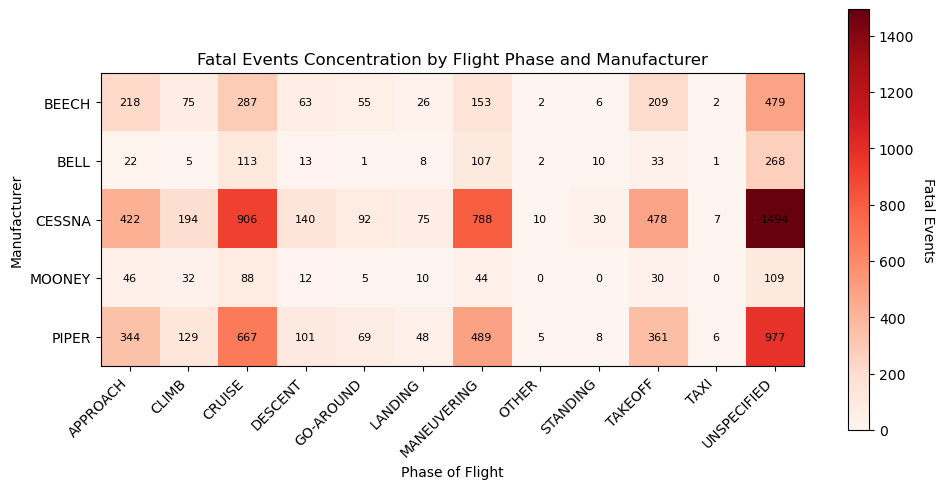

In [3]:
# Preparing for visualization showing whether these are concentrated in specific phases of flight
df45['Broad.phase.of.flight'] = (
    df45['Broad.phase.of.flight']
      .str.strip()
      .str.upper()
      .fillna('UNKNOWN')
)

# Pick top 5 manufacturers by fatal events
top_makes = (
    df45.groupby('Make')['FatalEvent']
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .index
)

# Aggregate by make + phase of flight
phase_stats = (
    df45[df45['Make'].isin(top_makes)]
      .groupby(['Make', 'Broad.phase.of.flight'])['FatalEvent']
      .sum()
      .reset_index()
)

pivot = phase_stats.pivot(
    index='Make',
    columns='Broad.phase.of.flight',
    values='FatalEvent'
).fillna(0)

pivot = pivot.rename(columns={'UNKNOWN': 'UNSPECIFIED'})

fig, ax = plt.subplots(figsize=(10, 5))

# Show the matrix using imshow
im = ax.imshow(pivot.values, cmap='Reds')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Fatal Events', rotation=270, labelpad=15)

# Set axis labels and ticks
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_yticks(np.arange(len(pivot.index)))

ax.set_xticklabels(pivot.columns, rotation=45, ha='right')
ax.set_yticklabels(pivot.index)

ax.set_title('Fatal Events Concentration by Flight Phase and Manufacturer')
ax.set_xlabel('Phase of Flight')
ax.set_ylabel('Manufacturer')

# Annotate cells with the event counts
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = int(pivot.values[i, j])
        ax.text(j, i, val, ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()


Insight:

The heat map shows that the fatal accidents of all major manufacturers are mainly concentrated in the cruise, maneuvering and approach stages. Cessna and Piper recorded the most accidents, reflecting their significant influence in the general aviation field, while Beechch, Mooney and Bell had smaller accident patterns. Except there being accident happended during unspecified phases, the accidents were concentrated in the mid-flight and approach phases, highlighting a higher risk of loss of control during high-demand flight phases. This may indicate that the accidents were more influenced by flight conditions rather than specific manufacturer defects.

Long-term trends indicate that the overall safety of aircraft from all major manufacturers has significantly improved over time. Fatal accidents peaked in the late 1970s and early 1980s, especially in Cessna and Piper, and then steadily declined in the 1990s and the 21st century. This downward trend is consistent with the progress of avionics, stricter regulatory standards, and the improvement of pilot training and maintenance practices. The decline in accidents at Beechch and Bell was small but continued, while Boeing's already low frequency of fatal accidents remained basically stable. Overall, the data indicates that the safety performance of the entire industry has been continuously improving significantly, and there are no signs of long-term deterioration in the safety performance of any manufacturer.

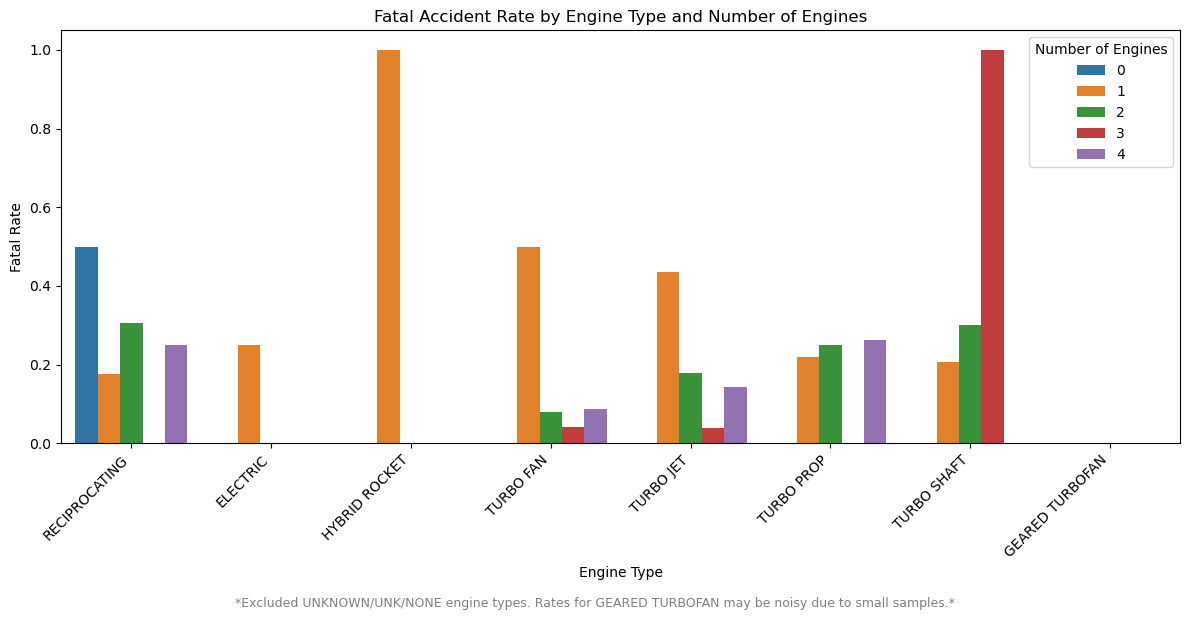

In [4]:
# 4.2 
df45['Engine.Type'] = df45['Engine.Type'].str.upper().fillna('UNKNOWN')
df45['Number.of.Engines'] = pd.to_numeric(df45['Number.of.Engines'], errors='coerce').round()

complexity_stats = (
    df45.groupby(['Number.of.Engines','Engine.Type'])
        .agg(TotalEvents=('Event.Id','count'),
             FatalEvents=('FatalEvent','sum'))
        .reset_index()
)
complexity_stats['FatalRate'] = complexity_stats['FatalEvents'] / complexity_stats['TotalEvents']
complexity_stats['Number.of.Engines'] = complexity_stats['Number.of.Engines'].astype('Int64')

# keep 0–4 engines and drop ambiguous engine types
drop_types = {'UNKNOWN','UNK','NONE'}
plot_df = complexity_stats[
    complexity_stats['Number.of.Engines'].isin([0,1,2,3,4]) &
    ~complexity_stats['Engine.Type'].isin(drop_types)
].copy()

plot_df['Number.of.Engines'] = plot_df['Number.of.Engines'].astype('category')
horder = [0,1,2,3,4]

plt.figure(figsize=(12,6))
sns.barplot(data=plot_df, x='Engine.Type', y='FatalRate',
            hue='Number.of.Engines', hue_order=horder)
plt.title("Fatal Accident Rate by Engine Type and Number of Engines")
plt.xlabel("Engine Type"); plt.ylabel("Fatal Rate")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Number of Engines")
plt.tight_layout()

# footnote
plt.figtext(
    0.5, -0.02,
    "*Excluded UNKNOWN/UNK/NONE engine types. Rates for GEARED TURBOFAN may be noisy due to small samples.*",
    ha='center', fontsize=9, color='gray'
)
plt.show()


Explanation:

The chart shows that single-engine and triple-engine aircraft, especially hybrid rocket types and turboshaft types, have the highest fatality rate. But generally speaking, the mortality rate of multi-engine and turbopowered aircraft is often much lower. This means that simple single-engine aircraft commonly seen in regular flights are more prone to fatal accidents, while aircraft with more engines or advanced turbine systems are usually safer because they have greater redundancy and stricter safety standards. "UNK/NKNOWN" is a placeholder code for unreported or undetected engine types, so they are removed to avoid comparisons. Categories like **gear turbofans** rarely appear in this dataset; Their mortality column is based on a very small sample, so we consider these values as high variance.

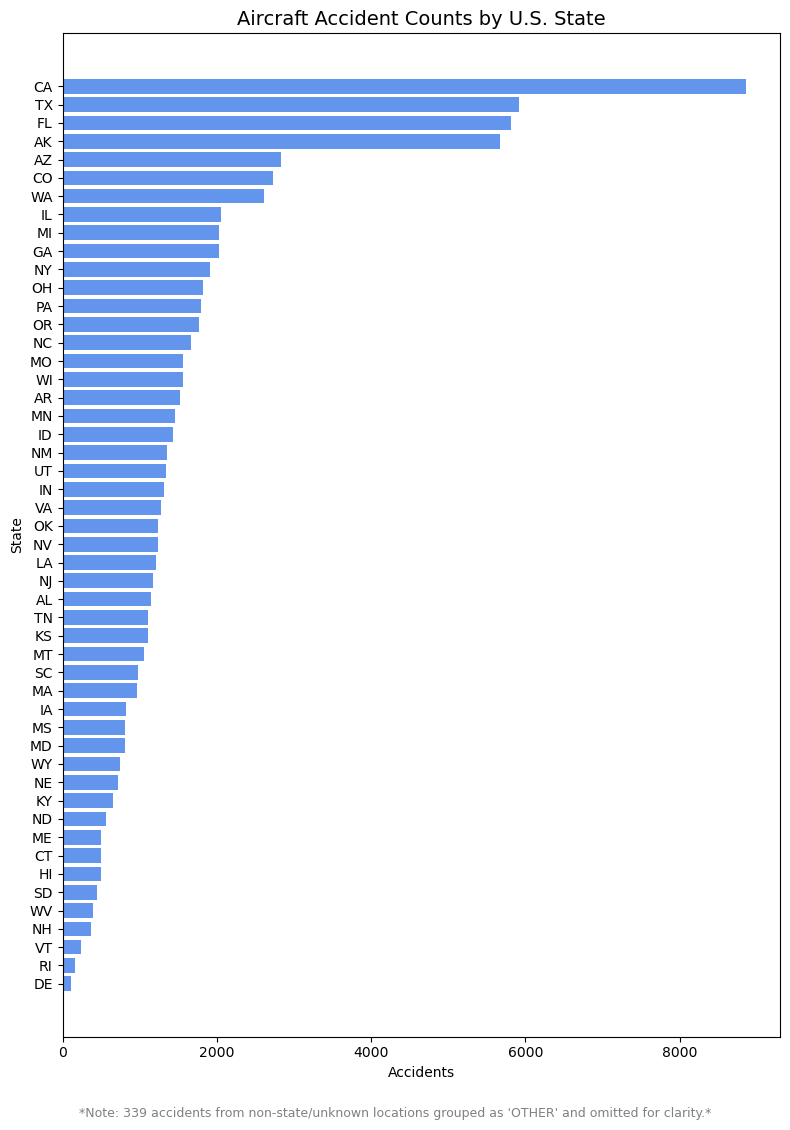

In [5]:
# 5.1 U.S. states (omit OTHER from plot, show total in note)

# Filter and extract 2-letter state codes
us_df = df45[df45['Country'].str.upper() == 'UNITED STATES'].copy()
us_df['State'] = (
    us_df['Location'].astype(str).str.split(',').str[-1].str.strip().str.upper()
)

# Valid 50-state set, else to OTHER
valid_states = {
 'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD',
 'MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
 'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'
}
us_df['State'] = us_df['State'].where(us_df['State'].isin(valid_states), 'OTHER')

# Aggregate counts
state_counts = (
    us_df.groupby('State')['Event.Id']
         .count()
         .reset_index(name='Accidents')
)

# Ensure all 50 states appear (fill 0); keep OTHER separately
all_states = pd.DataFrame({'State': sorted(valid_states)})
state_counts_50 = (
    all_states.merge(state_counts, on='State', how='left')
              .fillna({'Accidents': 0})
)
other_count = int(state_counts.loc[state_counts['State']=='OTHER', 'Accidents'].sum())

# Sort states by accidents (ascending) for plotting
plot_df = state_counts_50.sort_values(['Accidents','State'], ascending=[True, True])

# Omit OTHER bar, but report its size
plt.figure(figsize=(8,11))
plt.barh(plot_df['State'], plot_df['Accidents'], color='cornflowerblue')
plt.title('Aircraft Accident Counts by U.S. State', fontsize=14)
plt.xlabel('Accidents'); plt.ylabel('State')
plt.tight_layout()

# Note about OTHER underneath the figure
plt.figtext(
    0.5, -0.02,
    f"*Note: {other_count:,} accidents from non-state/unknown locations grouped as 'OTHER' and omitted for clarity.*",
    ha='center', fontsize=9, color='gray'
)

plt.show()

Persistent high-accident states: ['AK', 'AZ', 'CA', 'CO', 'FL', 'TX', 'WA']


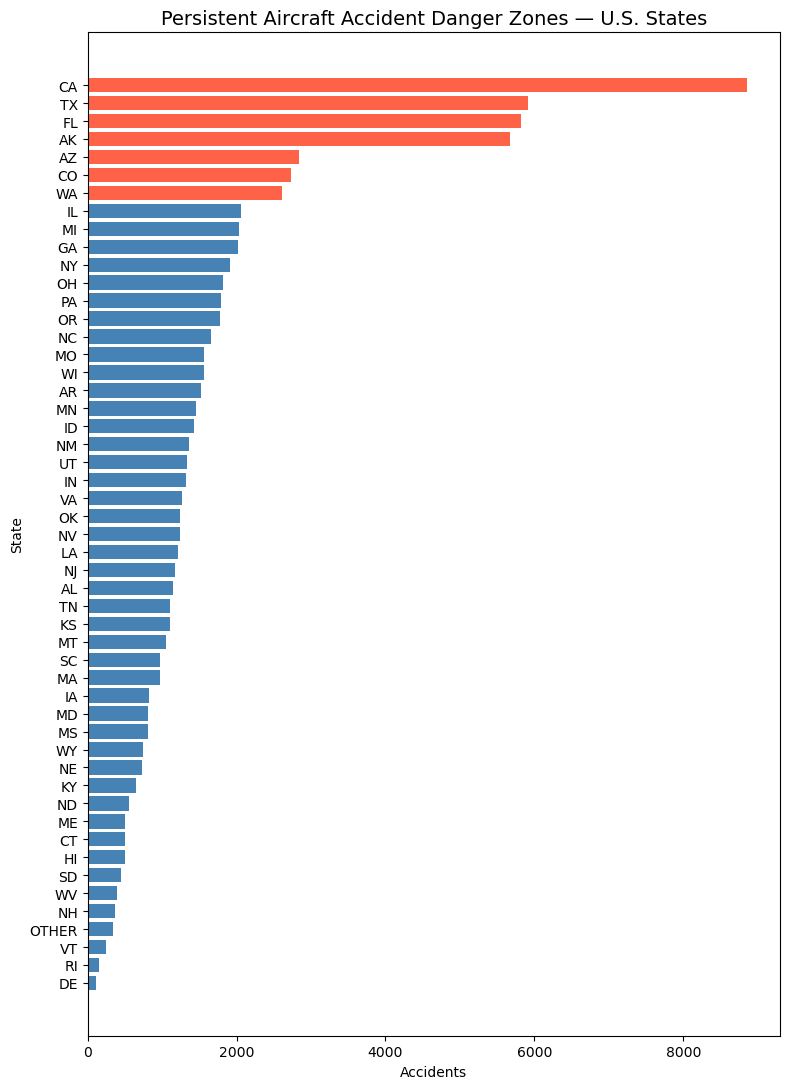

In [6]:
# 5.1.2 for U.S. prepare yearly totals by state
yearly_state = (
    us_df.groupby(['Year', 'State'])['Event.Id']
         .count()
         .reset_index(name='YearlyEvents')
)

# Identify top-quartile states each year
threshold = yearly_state['YearlyEvents'].quantile(0.75)
flags = (
    yearly_state.assign(Top = yearly_state['YearlyEvents'] >= threshold)
                .groupby('State')['Top']
                .mean()
                .rename('TopShare')
                .reset_index()
)

# Mark persistent states (>= 60% of years in top quartile)
persistent_states = flags.loc[flags['TopShare'] >= 0.6, 'State'].tolist()
print("Persistent high-accident states:", persistent_states)

# Merge with total accident counts
plot_df = (
    us_df.groupby('State')['Event.Id']
         .count()
         .reset_index(name='Accidents')
         .sort_values('Accidents', ascending=True)
)

# Highlight persistent states in red
colors = ['tomato' if s in persistent_states else 'steelblue' for s in plot_df['State']]

plt.figure(figsize=(8,11))
plt.barh(plot_df['State'], plot_df['Accidents'], color=colors)
plt.title('Persistent Aircraft Accident Danger Zones — U.S. States', fontsize=14)
plt.xlabel('Accidents')
plt.ylabel('State')
plt.tight_layout()
plt.show()

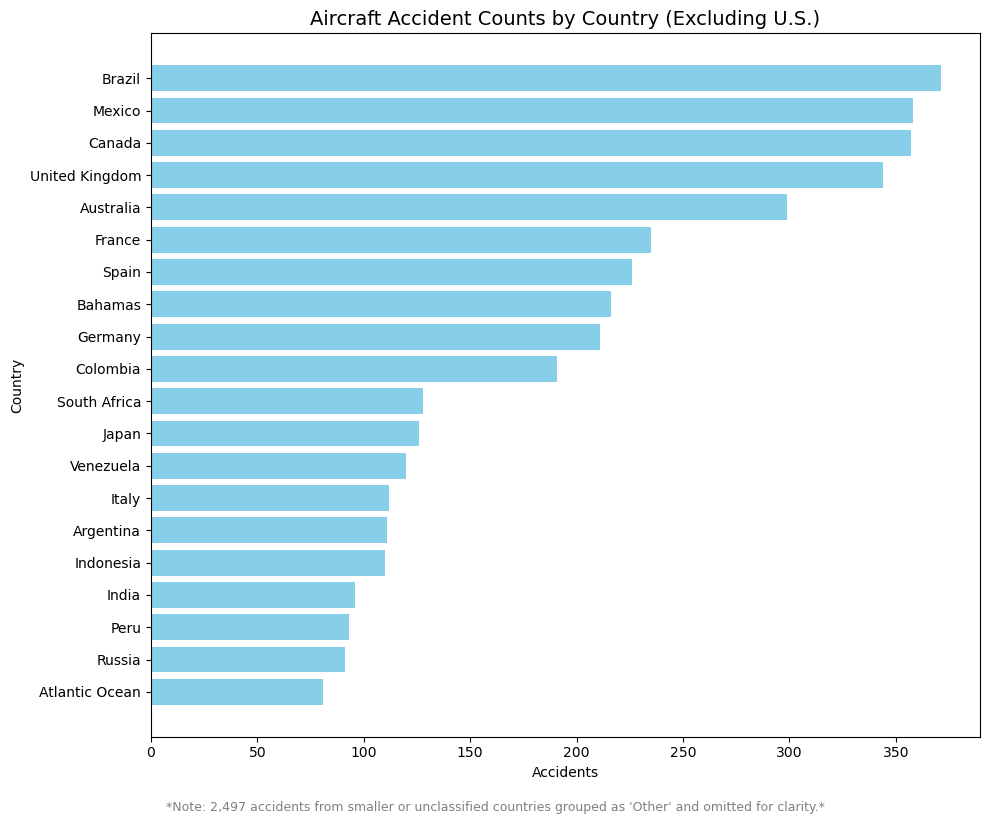

In [7]:
# 5.1, filter non-U.S. data
world_df = df45[df45['Country'].str.upper() != 'UNITED STATES'].copy()

# Clean up country names
world_df['Country'] = world_df['Country'].str.strip().str.title()

# 2. Aggregate by country
country_counts = (
    world_df.groupby('Country')['Event.Id']
            .count()
            .reset_index(name='Accidents')
            .sort_values('Accidents', ascending=False)
)

# Keep only top 20 countries
top_n = 20
top_countries = country_counts.head(top_n)
other_total = country_counts['Accidents'][top_n:].sum()

# Combine only top countries for plotting
summary = top_countries.copy()

# Plot horizontal bar chart
plt.figure(figsize=(10,8))
plt.barh(summary['Country'], summary['Accidents'], color='skyblue')
plt.title('Aircraft Accident Counts by Country (Excluding U.S.)', fontsize=14)
plt.xlabel('Accidents')
plt.ylabel('Country')
plt.gca().invert_yaxis()  # largest on top
plt.tight_layout()

# Add note about omitted "Other" total
plt.figtext(
    0.5, -0.02,
    f"*Note: {other_total:,} accidents from smaller or unclassified countries grouped as 'Other' and omitted for clarity.*",
    ha='center', fontsize=9, color='gray'
)
plt.show()


Persistent high-accident countries among plotted:
['Atlantic Ocean', 'Australia', 'Bahamas', 'Brazil', 'Canada', 'Colombia', 'France', 'Germany', 'Indonesia', 'Japan', 'Mexico', 'Spain', 'United Kingdom', 'Venezuela']


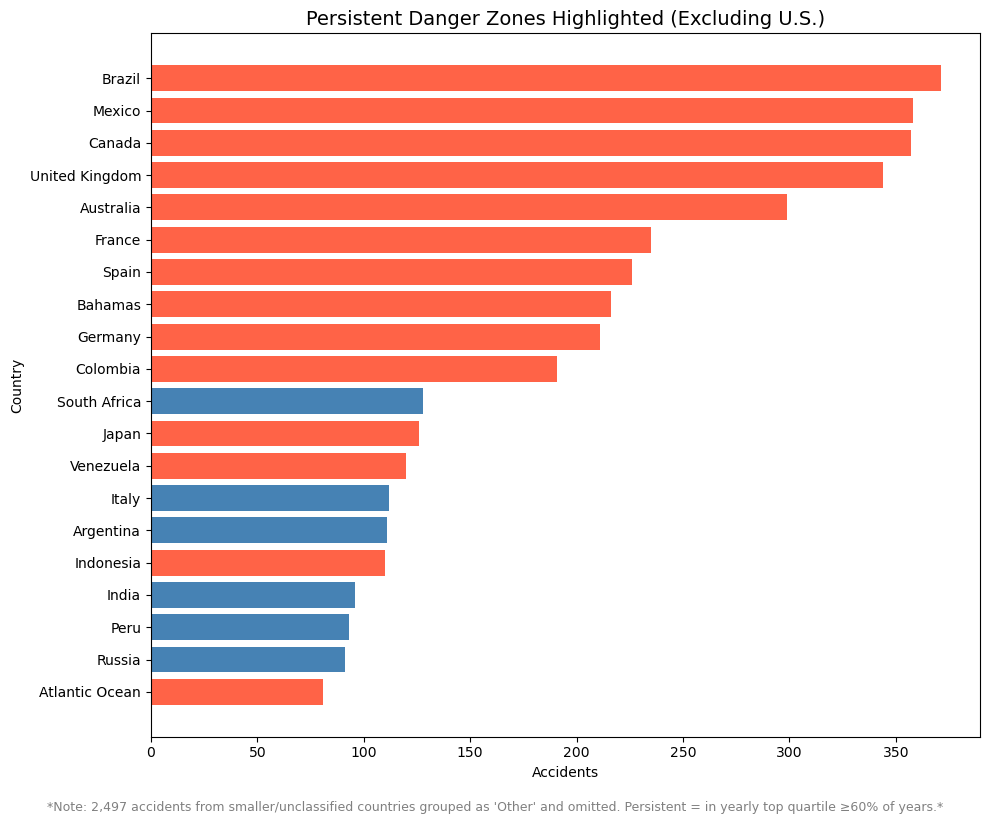

In [8]:
# 5.1.2 for non-U.S. data
world_df = df45[df45['Country'].str.upper() != 'UNITED STATES'].copy()

# Clean up country names and remove blanks
world_df['Country'] = world_df['Country'].astype(str).str.strip().str.title()
world_df = world_df[world_df['Country'].notna() & (world_df['Country'] != '') & (world_df['Country'] != 'Nan')]

# 1) Aggregate by country
country_counts = (
    world_df.groupby('Country')['Event.Id']
            .count()
            .reset_index(name='Accidents')
            .sort_values('Accidents', ascending=False)
)

# Keep only top 20 countries
top_n = 20
top_countries = country_counts.head(top_n).copy()
other_total = int(country_counts['Accidents'][top_n:].sum())

# 2) Compute persistence
yearly_country = (
    world_df.groupby(['Year', 'Country'])['Event.Id']
            .count()
            .reset_index(name='YearlyEvents')
)
yearly_country['YearThreshold'] = (
    yearly_country.groupby('Year')['YearlyEvents'].transform(lambda s: s.quantile(0.75))
)
yearly_country['Top'] = yearly_country['YearlyEvents'] >= yearly_country['YearThreshold']

flags = (
    yearly_country.groupby('Country')['Top']
                  .mean()
                  .rename('TopShare')
                  .reset_index()
)
persistent_countries = set(flags.loc[flags['TopShare'] >= 0.60, 'Country'])

# Restrict persistence highlight to countries shown in the chart (top 20)
summary = top_countries.copy()
summary['Persistent'] = summary['Country'].isin(persistent_countries)

print("Persistent high-accident countries among plotted:")
print(sorted(summary.loc[summary['Persistent'], 'Country'].tolist()))

# 3) Plot horizontal bar chart with persistent countries highlighted
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
colors = ['tomato' if p else 'steelblue' for p in summary['Persistent']]
plt.barh(summary['Country'], summary['Accidents'], color=colors)
plt.title('Persistent Danger Zones Highlighted (Excluding U.S.)', fontsize=14)
plt.xlabel('Accidents')
plt.ylabel('Country')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.figtext(
    0.5, -0.02,
    f"*Note: {other_total:,} accidents from smaller/unclassified countries grouped as 'Other' and omitted."
    " Persistent = in yearly top quartile ≥60% of years.*",
    ha='center', fontsize=9, color='gray'
)
plt.show()


In [9]:
# U.S. vs Worldwide accident comparison
accident_counts = (
    df45.assign(LocationType = df45['Country']
                .str.upper()
                .apply(lambda x: 'UNITED STATES' if x == 'UNITED STATES' else 'OTHER COUNTRIES'))
      .groupby('LocationType')['Event.Id']
      .count()
      .reset_index(name='Accidents')
)

# percentage comparison
accident_counts['Percent'] = 100 * accident_counts['Accidents'] / accident_counts['Accidents'].sum()

accident_counts


,LocationType,Accidents,Percent
0,OTHER COUNTRIES,6598,7.43018
1,UNITED STATES,82202,92.56982


Explanation:

The dataset shows that approximately 92.56% of all recorded accidents occur within the United States, with the remaining 7.43% reported from other countries.

In the global chart, countries such as Brazil, Mexico, Canada and Australia have seen persistently high accident rates due to the large scale of their aviation industries.

In the chart of the United States, states such as California, Texas, Florida and Alaska have consistently maintained high levels due to busy flight traffic and challenging flight conditions.

Ovesrall, highlighted orange indicates a long-term and consistent frequency of accidents and does not necessarily mean poor safety.

For the second part of 5.1, persistence is determined by grouping accident counts by year and region, and then ranking them annually. If a region is in the top quarter of the number of accidents in at least 60% of the years, it is marked as a persistent danger zone. This means that the number of its accidents has remained high rather than rising briefly. For instance, by using the groupby (['Year', 'Country']) and quantile (0.75) threshold, the calculated TopShare shows which regions (such as Brazil or California) maintain a high accident frequency year after year, indicating that exposure and activity levels have stabilized over time.

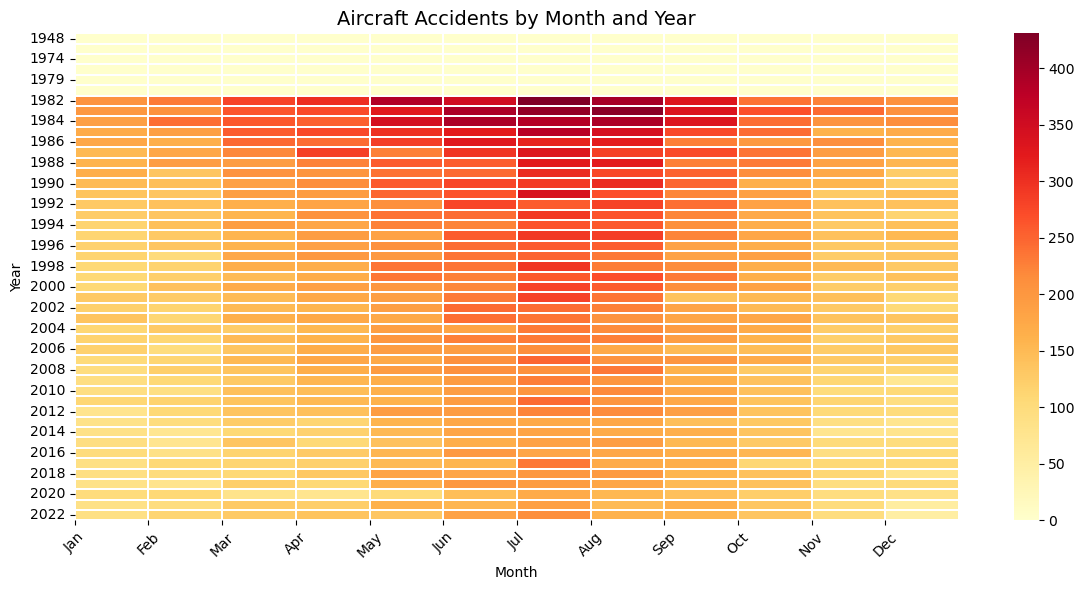

In [10]:
# 5.2
# Ensure Event.Date is a proper datetime
df45['Event.Date'] = pd.to_datetime(df45['Event.Date'], errors='coerce')

# Extract year and month
df45['Year'] = df45['Event.Date'].dt.year
df45['Month'] = df45['Event.Date'].dt.month

# Remove invalid/missing dates
df = df45.dropna(subset=['Year', 'Month'])

# Group by year and month for accident counts
monthly_counts = (
    df45.groupby(['Year', 'Month'])['Event.Id']
      .count()
      .reset_index(name='Accidents')
)

# Pivot into a Year × Month grid
heatmap_data = monthly_counts.pivot(index='Year', columns='Month', values='Accidents').fillna(0)

# Sort years ascending 
heatmap_data = heatmap_data.sort_index(ascending=True)

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    linewidths=0.3,
    linecolor='white'
)

plt.title('Aircraft Accidents by Month and Year', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Year')
plt.xticks(
    ticks=range(0, 12),
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    rotation=45
)
plt.tight_layout()
plt.show()


Insight:
The calendar heat map shows the seasonal pattern, with the highest accident frequency from May to September, especially around July to August. This is the time for a large number of leisure flights and training activities, which indicates the need to enhance pilot training, maintenance inspections, and discussions related to the weather in summer.

State-level hazard zone charts indicate that the number of accidents in states such as California, Texas, Florida and Alaska in the United States has remained consistently high. These regions combine dense general aviation traffic, complex territories and constantly changing weather, so local authorities can enhance runway safety measures, mountain flight training and infrastructure monitoring in these areas.

Globally, national-level charts show that Brazil, Mexico, Canada and Australia have consistently reported the highest average number of accidents. These countries have vast airspace and active general aviation sectors, which indicates the need for regional safety audits, improvements in airport management and standardized flight reporting systems to mitigate recurring risks.